In [1]:
import json
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import category_encoders
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True) 

In [11]:
def remove_columns_with_a_single_value(original_dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Removes all columns that only contain one possible value and therefore do not provide any useful information for the neural network.

    Columns with a single unique do not provide any information for the neural network, since every possible sample will have the same value. 

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to check for columns with single unique values.

    Returns: 
        pd.DataFrame: A modified version of the input DataFrame.
        Note: All columns with a single unique value are dropped.
    """
    return original_dataframe[[column for column in original_dataframe.columns if len(original_dataframe[column].unique()) > 1]]

def encode_cyclic_feature(original_dataframe: pd.DataFrame, column_to_encode: str, period: int) -> pd.DataFrame:
    """
    Encodes a cyclical feature in a DataFrame column using a cosine and sine transformation, 
    to let the neural network correctly learn periodic patterns.

    The original feature (e.g. time, date) gets split up into two new columns.
    A cosine and a sine column while the original column gets dropped.
    
    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to modify the cyclical features column. 
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        period (int):  The timeframe of a single cycle in the column to be encoded. 

    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the {column_to_encode} replaced by two new columns:
            - {column_to_encode}_sin: The sine-transformed cyclical feature.
            - {column_to_encode}_cos: The cosine-transformed cyclical feature.
        Note: The {column_to_encode} is dropped from the DataFrame after encoding.
    """
    original_dataframe[column_to_encode] = original_dataframe[column_to_encode].astype('float64')
    original_dataframe[column_to_encode + '_sin'] = np.sin(2 * np.pi * original_dataframe[column_to_encode] / period)
    original_dataframe[column_to_encode + '_cos'] = np.cos(2 * np.pi * original_dataframe[column_to_encode] / period)
    original_dataframe = original_dataframe.drop(columns=column_to_encode)
    return original_dataframe

def encode_utc_timestamps_with_two_different_patterns(original_dataframe: pd.DataFrame, column_to_encode: str, patterns: list[str]) -> pd.DataFrame:
    """ 
    Encodes a utc timestamp in a DataFrame column to a unix timestamp, to convert the timestamp into an int, 
    that can be used as input feature for the neural network.

    Iterates over all entries in the {column_to_encode}, transforms them into an unix timestamp.
    These unix timestamps then get added to a list containing all timestamps. 
    After iterating over all entries the values in the {column_to_encode} get substituted with the list of timestamps. 
    
    Used for columns with two different possible utc patterns.

    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to encode the utc timestamp.
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        patterns (list[str]): A list of two different string patterns of the timestamp in the {column_to_encode}:
            - The first pattern contains the pattern with a period.
            - The second pattern contains the pattern without the period.
    
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the {column_to_encode} encoded to a unix timestamp.
    """
    timestamps = []
    for i in range(len(original_dataframe)):
        time_stamp = original_dataframe.loc[i, column_to_encode]
        if time_stamp.__contains__("."):
            pattern = patterns[0]
        else: 
            pattern = patterns[1]
        time_stamp = datetime.strptime(original_dataframe.loc[i, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe

def encode_utc_timestamp(original_dataframe: pd.DataFrame, column_to_encode: str, pattern: str) -> pd.DataFrame:
    """ 
    Encodes a utc timestamp in a DataFrame column to a unix timestamp, to convert the timestamp into an int, 
    that can be used as input feature for the neural network.

    Iterates over all entries in the {column_to_encode}, transforms them into an unix timestamp.
    These unix timestamps then get added to a list containing all timestamps. 
    After iterating over all entries the values in the {column_to_encode} get substituted with the list of timestamps. 
    
    Args:
        original_dataframe (pd.DataFrame): The input DataFrame to encode the utc timestamp.
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        pattern (str): The string pattern of the timestamp in the {column_to_encode}.
    
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with the {column_to_encode} encoded to a unix timestamp.
    """

    timestamps = []
    for i in range(len(original_dataframe)):
        time_stamp = original_dataframe.loc[i, column_to_encode]
        time_stamp = datetime.strptime(original_dataframe.loc[i, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe

def number_of_unique_values_per_column(dataframe: pd.DataFrame) -> list[(str, int)]:
    """ 
    Returns a list of tuples containing column names and the amount of unique values in this column.

    Args:  
        original_dataframe (pd.DataFrame): The input DataFrame to determine the number of unique values per column.

    Returns:
        list[(str, int)]: A list of tuples where each tuple contains:
            - The column name as a string.
            - The amount of unique values in that column as an integer.
    """
    return [(column, dataframe[column].nunique()) for column in dataframe.columns]

def onehot_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    One-hot encodes the passed column of the DataFrame. 
    
    One-hot encoding is a technique used to convert categorical variables into a numerical representation,
    which is necessary for nominal features without an inherent order.
    This guarantees that the neural network can correctly learn from the data without implying any ordinal relationships.

    One-hot encoding splits the specified column by creating new binary columns for each unique value present in the column.
    Each binary column represents if the corresponding value is present for the row in the DataFrame.

    Args:  
        original_dataframe (pd.DataFrame): The input DataFrame to determine the number of unique values per column.
        column_to_encode (str): The name of the column to modify in the input DataFrame.
        
    Returns:
        pd.DataFrame: A modified version of the input DataFrame with one-hot encoded columns for the {column_to_encode}
        Note: If the {column_to_encode} is not 'session_id', the {column_to_encode} is dropped from the DataFrame after encoding.
        The 'session_id' column is still needed later on when looking for the classification for the y_sets. 
    """
    encoder = OneHotEncoder()
    encoded_column = encoder.fit_transform(original_dataframe[[column_to_encode]])
    encoded_column_dataframe = pd.DataFrame(encoded_column.toarray(), columns=encoder.get_feature_names_out([column_to_encode]))
    original_dataframe = pd.concat([original_dataframe, encoded_column_dataframe], axis=1)

    if column_to_encode != "session_id":
        original_dataframe = original_dataframe.drop(columns=[column_to_encode])

    return original_dataframe

def label_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    Args:

    Returns:
    
    """
    label_encoder = LabelEncoder()
    original_dataframe[column_to_encode] = label_encoder.fit_transform(original_dataframe[column_to_encode])
    return original_dataframe

def encode_boolean(original_dataframe: pd.DataFrame, columns_to_encode: list[str]) -> pd.DataFrame:
    """ 
    Args:

    Returns:
    
    """
    for index in range(0, len(columns_to_encode)):
        original_dataframe[columns_to_encode[index]] = original_dataframe[columns_to_encode[index]].astype('int')
    return original_dataframe

def category_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    Args:

    Returns:
    
    """
    binary_encoder = category_encoders.BinaryEncoder(cols=column_to_encode)
    original_dataframe = binary_encoder.fit_transform(original_dataframe)
    return original_dataframe

def encode_str_to_enum(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    Args:

    Returns:
    
    """
    encoding_dict = dict()
    encoded_value = 0
    for index in range(len(original_dataframe)):
        value = original_dataframe.iloc[index][column_to_encode]
        if value in encoding_dict:
            original_dataframe.at[index, column_to_encode] = encoding_dict[value]
        else: 
            encoding_dict[value] = encoded_value
            original_dataframe.at[index, column_to_encode] = encoded_value
            encoded_value += 1
    return original_dataframe

def encode_date(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    """ 
    Args:

    Returns:
    
    """
    for _, row in original_dataframe.iterrows():
        date_object = datetime.strptime(row[column_to_encode], "%Y-%m-%d")
        original_dataframe[column_to_encode] = date_object.toordinal()
    return original_dataframe

def encode_weather_enums(original_dataframe: pd.DataFrame, json_subarray_name: str, json_key: str) -> pd.DataFrame:
    """ 
    Args:

    Returns:
    
    """
    weather_day_data = parsed_json[json_subarray_name][json_key]
    for index in range(0, len(original_dataframe)):
        for key, value in weather_day_data.items():
            if original_dataframe.loc[index, f'weather_hour_id {json_key}'] == value:
                original_dataframe.loc[index, f'weather_hour_id {json_key}'] = key     
    return original_dataframe

def move_column_to_the_front(original_dataframe: pd.DataFrame, column_to_move: str) -> pd.DataFrame:
    """ 
    Args:

    Returns:
    
    """    
    first_column = original_dataframe.pop(column_to_move)
    original_dataframe.insert(0, column_to_move, first_column)
    return original_dataframe

def get_weather_data(original_dataframe: pd.DataFrame, column_to_encode: str, json_subarray_name: str) -> pd.DataFrame:
    """ 
    Args:

    Returns:
    
    """
    weather_data_list = []
    
    for _, row in original_dataframe.iterrows():
        weather_day_id = row[column_to_encode]
        weather_day_data = parsed_json[json_subarray_name][str(weather_day_id)]
        weather_day_data = {f"{column_to_encode} {k}": v for k, v in weather_day_data.items() if k != 'id'}
        weather_data_list.append(weather_day_data)
    weather_data_df = pd.DataFrame(weather_data_list)
    weather_data_df = remove_columns_with_a_single_value(weather_data_df)
    
    if column_to_encode == "weather_day_id":
        weather_data_df = encode_utc_timestamp(weather_data_df, f'{column_to_encode} sun_set', "%Y-%m-%dT%H:%M:%S%z")
        weather_data_df = encode_utc_timestamp(weather_data_df, f'{column_to_encode} sun_rise', "%Y-%m-%dT%H:%M:%S%z")
        weather_data_df = encode_utc_timestamp(weather_data_df, f'{column_to_encode} created_at', "%Y-%m-%dT%H:%M:%S.%f%z")
        weather_data_df = encode_utc_timestamp(weather_data_df, f'{column_to_encode} calculated_at', "%Y-%m-%dT%H:%M:%S%z")

    elif column_to_encode == "weather_hour_id":
        weather_data_df = encode_utc_timestamp(weather_data_df, f'{column_to_encode} created_at', "%Y-%m-%dT%H:%M:%S.%f%z")
        weather_data_df = encode_utc_timestamp(weather_data_df, f'{column_to_encode} calculated_at', "%Y-%m-%dT%H:%M:%S%z")
        weather_data_df = encode_utc_timestamp(weather_data_df, f'{column_to_encode} forecast_time', "%Y-%m-%dT%H:%M:%S%z")

    original_dataframe = pd.concat([original_dataframe, weather_data_df], axis=1)
    return original_dataframe

In [18]:
# read json data
with open("datasets\\transfer\\smaller_dataset.json") as file:
    parsed_json = json.load(file)

# build dataframe 
total_amount_of_rows = 0
all_sessions = pd.DataFrame()
for i in pd.json_normalize(parsed_json['traces']):
    total_amount_of_rows += len(pd.json_normalize(parsed_json['traces'][i]))
    single_session = pd.json_normalize(parsed_json['traces'][i])
    all_sessions = pd.concat([all_sessions, single_session], ignore_index=True)

all_sessions = all_sessions.drop(columns=['weather_future_day_id', 'weather_future_hour_id'])

all_sessions = all_sessions.infer_objects(copy=False)
null_columns = all_sessions.columns[all_sessions.isnull().any()]
print(null_columns)

null_columns = all_sessions.columns[all_sessions.isnull().any()]
print(null_columns)
for column in null_columns:
    all_sessions[column] = all_sessions[column].fillna(all_sessions[column].mode()[0])

null_columns = all_sessions.columns[all_sessions.isnull().any()]

all_sessions = encode_cyclic_feature(all_sessions, 'time_hod', 24)
all_sessions = encode_cyclic_feature(all_sessions, 'time_dow', 7)
all_sessions = encode_utc_timestamps_with_two_different_patterns(all_sessions, 'time_local', ['%Y-%m-%dT%H:%M:%S.%f', '%Y-%m-%dT%H:%M:%S'])
all_sessions = encode_utc_timestamps_with_two_different_patterns(all_sessions, 'time_utc', ['%Y-%m-%dT%H:%M:%S.%fZ', '%Y-%m-%dT%H:%M:%SZ'])
all_sessions = encode_boolean(all_sessions, ['device_online'])
all_sessions = encode_str_to_enum(all_sessions, 'content_portal')


# get more in-depth weather data
all_sessions = get_weather_data(all_sessions, 'weather_day_id', 'weather_day_map')
all_sessions = get_weather_data(all_sessions, 'weather_hour_id', 'weather_hour_map')

# too many null values
all_sessions = all_sessions.drop(columns=['weather_day_id moon_set', 'weather_day_id moon_rise'])
all_sessions = all_sessions.drop(columns=['weather_day_id', 'weather_hour_id'])

# encode non int values from the weather data
all_sessions = encode_date(all_sessions, 'weather_day_id forecast_date')
all_sessions = encode_weather_enums(all_sessions, 'weather_enums', 'wind_strength')
all_sessions = encode_weather_enums(all_sessions, 'weather_enums', 'wind_direction')
all_sessions = encode_weather_enums(all_sessions, 'weather_enums', 'thunderstorm_prob')

ohe_features = ['content_portal', 'device_online', 'device_class', 'device_orientation', 'oha_language_iso2', 'oha_layout', 'weather_hour_id thunderstorm_prob', 'weather_day_id thunderstorm_prob', 'weather_hour_id wind_strength', 'weather_day_id wind_strength']
numerical_features = ['time_utc', 'time_local', 'device_height_px', 'device_width_px']
numerical_features2 = ['weather_day_id sun_set', 'weather_day_id sun_rise', 'weather_day_id created_at', 'weather_day_id sunshine_h', 'weather_day_id temp_max_c', 'weather_day_id temp_min_c', 'weather_day_id calculated_at', 'weather_day_id forecast_date', 'weather_day_id prec_prob_pct', 'weather_day_id prec_rain_mm_h', 'weather_day_id prec_snow_mm_h', 'weather_day_id wind_speed_kmh', 'weather_day_id prec_total_mm_h', 'weather_day_id temp_felt_max_c', 'weather_day_id temp_felt_min_c', 'weather_day_id humidity_mean_pct', 'weather_day_id wind_speed_max_kmh', 'weather_day_id cloud_cover_max_pct', 'weather_day_id cloud_cover_min_pct', 'weather_day_id cloud_cover_mean_pct', 'weather_hour_id temp_c', 'weather_hour_id created_at', 'weather_hour_id sunshine_h', 'weather_hour_id temp_felt_c', 'weather_hour_id humidity_pct', 'weather_hour_id calculated_at', 'weather_hour_id forecast_time', 'weather_hour_id prec_rain_mm_h', 'weather_hour_id prec_snow_mm_h', 'weather_hour_id wind_speed_kmh', 'weather_hour_id cloud_cover_pct', 'weather_hour_id prec_total_mm_h', 'weather_hour_id forecast_distance_h']

binary_features = ['device_country_iso2', 'device_language_iso2', 'event_type', 'device_platform', 'weather_hour_id wind_direction', 'weather_day_id wind_direction', 'weather_day_id moon_phase']
embedded_features = ['content_id', 'device_id', 'session_id']

for column in embedded_features:
    all_sessions = label_encode_column(all_sessions, column)
    all_sessions = move_column_to_the_front(all_sessions, column)

scaler = StandardScaler()
for column in numerical_features:
    all_sessions[column] = scaler.fit_transform(np.array(all_sessions[column]).reshape(-1, 1))
for column in numerical_features2:
    all_sessions[column] = scaler.fit_transform(np.array(all_sessions[column]).reshape(-1, 1))

one_hot_encoder = OneHotEncoder()
for column in ohe_features:
    all_sessions = onehot_encode_column(all_sessions, column)

for column in binary_features:
    #all_sessions = onehot_encode_column(all_sessions, column)
    all_sessions = category_encode_column(all_sessions, column)

print(all_sessions.isnull().sum().sum())

all_sessions[f'prev_content_id'] = all_sessions['content_id'].shift(1)
all_sessions[f'prev_prev_content_id'] = all_sessions['content_id'].shift(2)

all_sessions = move_column_to_the_front(all_sessions, 'prev_prev_content_id')
all_sessions = move_column_to_the_front(all_sessions, 'prev_content_id')
all_sessions.fillna({'prev_content_id': 39}, inplace=True)
all_sessions.fillna({'prev_prev_content_id': 39}, inplace=True)

'''
print(all_sessions.iloc[0])
all_sessions.fillna({'prev_prev_event': 39}, inplace=True)
all_sessions = move_column_to_the_front(all_sessions, 'prev_prev_event')
'''

unique_classifications = all_sessions['content_id'].nunique()

# build features vectors
feature_vectors = []
for i in range(0, len(all_sessions)):
    if i < len(all_sessions) - 1:
        if all_sessions.iloc[i]['session_id'] == all_sessions.iloc[i+1]['session_id']:
            feature_vector = (all_sessions.iloc[i], all_sessions.iloc[i+1]['content_id']) 
            feature_vectors.append(feature_vector)

# shuffle dataset
#random.shuffle(feature_vectors)

# build train / test sets
input_features = []
classification_labels = []

for input_feature, classification in feature_vectors:
    input_features.append(input_feature)
    classification_labels.append(classification)

input_features_array = np.array(input_features)
classification_labels_array = np.array(classification_labels)

ros = RandomOverSampler(random_state=42)
input_resampled, classification_resampled = ros.fit_resample(input_features_array, classification_labels_array)

X_train, X_test, y_train, y_test = train_test_split(input_resampled, classification_resampled, test_size=0.2, random_state=42)

print(number_of_unique_values_per_column(all_sessions))
print(unique_classifications)

Index(['oha_layout', 'device_class', 'device_platform', 'device_width_px',
       'device_height_px', 'device_orientation', 'device_country_iso2'],
      dtype='object')
Index(['oha_layout', 'device_class', 'device_platform', 'device_width_px',
       'device_height_px', 'device_orientation', 'device_country_iso2'],
      dtype='object')
0
[('prev_content_id', 40), ('prev_prev_content_id', 40), ('session_id', 80), ('device_id', 29), ('content_id', 39), ('time_utc', 264), ('event_type_0', 2), ('event_type_1', 2), ('event_type_2', 2), ('time_local', 264), ('device_platform_0', 2), ('device_platform_1', 2), ('device_platform_2', 2), ('device_width_px', 14), ('device_height_px', 13), ('device_country_iso2_0', 2), ('device_country_iso2_1', 2), ('device_country_iso2_2', 2), ('device_language_iso2_0', 2), ('device_language_iso2_1', 2), ('device_language_iso2_2', 2), ('time_hod_sin', 16), ('time_hod_cos', 16), ('time_dow_sin', 7), ('time_dow_cos', 7), ('weather_day_id sun_set', 40), ('weather_

In [31]:
print(X_train.shape)

X_train_prev_event, X_train = X_train[:, :1], X_train[:, 1:]
X_train_prev_prev_event, X_train = X_train[:, :1], X_train[:, 1:]
X_train_session_id, X_train = X_train[:, :1], X_train[:, 1:]
X_train_device_id, X_train = X_train[:, :1], X_train[:, 1:]
X_train_content_id, X_train = X_train[:, :1], X_train[:, 1:]

X_train_prev_event_input_dim = len(set(X_train_prev_event.flatten()))
X_train_prev_prev_event_input_dim = len(set(X_train_prev_event.flatten()))

print(X_train.shape)

X_test_prev_event, X_test = X_test[:, :1], X_test[:, 1:]
X_test_prev_prev_event, X_test = X_test[:, :1], X_test[:, 1:]
X_test_session_id, X_test = X_test[:, :1], X_test[:, 1:]
X_test_device_id, X_test = X_test[:, :1], X_test[:, 1:]
X_test_content_id, X_test = X_test[:, :1], X_test[:, 1:]

(1080, 90)
(1080, 85)


In [33]:
def model_builder(hp):
    hp_output1 = hp.Int('output_dim_prev_event', min_value=5, max_value=40, step=5)
    hp_output2 = hp.Int('output_dim_prev_prev_event', min_value=5, max_value=40, step=5)
    hp_output3 = hp.Int('output_dim_session_id', min_value=5, max_value=40, step=5)
    hp_output4 = hp.Int('output_dim_device_id', min_value=5, max_value=40, step=5)
    hp_output5 = hp.Int('output_dim_output', min_value=5, max_value=40, step=5)

    embedding_input_prev_event = tf.keras.layers.Input(shape=(1,), dtype='int32') 
    embedding_layer_prev_event = tf.keras.layers.Embedding(input_dim=X_train_prev_event_input_dim, output_dim=hp_output1)(embedding_input_prev_event)
    flattened_prev_event = tf.keras.layers.Flatten()(embedding_layer_prev_event)

    embedding_input_prev_prev_event = tf.keras.layers.Input(shape=(1,), dtype='int32') 
    embedding_layer_prev_prev_event = tf.keras.layers.Embedding(input_dim=X_train_prev_prev_event_input_dim, output_dim=hp_output2)(embedding_input_prev_prev_event)
    flattened_prev_prev_event = tf.keras.layers.Flatten()(embedding_layer_prev_prev_event)
    
    embedding_input_session_id = tf.keras.layers.Input(shape=(1,), dtype='int32') 
    embedding_layer_session_id = tf.keras.layers.Embedding(input_dim=80, output_dim=hp_output3)(embedding_input_session_id)
    flattened_session_id = tf.keras.layers.Flatten()(embedding_layer_session_id)

    embedding_input_device_id = tf.keras.layers.Input(shape=(1,), dtype='int32') 
    embedding_layer_device_id = tf.keras.layers.Embedding(input_dim=29, output_dim=hp_output4)(embedding_input_device_id)
    flattened_device_id = tf.keras.layers.Flatten()(embedding_layer_device_id)

    concatenated_embeddings = tf.keras.layers.Concatenate()([flattened_prev_event, flattened_prev_prev_event, flattened_session_id, flattened_device_id])

    flattened_input = tf.keras.layers.Input(shape=(X_train.shape[1],))
    flattened = tf.keras.layers.Flatten()(flattened_input)
    concatenated = tf.keras.layers.Concatenate()([concatenated_embeddings, flattened])
    
    hp_units = hp.Int('units', min_value=16, max_value=1024, step=32)
    hp_layers = hp.Int('layers', min_value=2, max_value=15, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01])
    hp_optimizer = hp.Choice('optimizer', values=['adam'])
    hp_regularization = hp.Choice('regularization', values=['l1', 'l2', 'l1_l2'])
    hp_lambda = hp.Float('lambda', min_value=0.5, max_value=1.0, step=0.01)
    
    for i in range(hp_layers):
        if hp_regularization == 'l1':
            regularizer = tf.keras.regularizers.l1(hp_lambda)
        elif hp_regularization == 'l2':
            regularizer = tf.keras.regularizers.l2(hp_lambda)
        else: # l1_l2
            regularizer = tf.keras.regularizers.l1_l2(l1=hp_lambda, l2=hp_lambda)
        
        concatenated = tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizer)(concatenated)
        concatenated = tf.keras.layers.BatchNormalization()(concatenated)
        concatenated = tf.keras.layers.Dropout(0.3)(concatenated)    

    output_embedding_input = tf.keras.layers.Input(shape=(1,), dtype='int32')
    output_embedding_layer = tf.keras.layers.Embedding(input_dim=unique_classifications, output_dim=hp_output5)(output_embedding_input)
    flattened_output_embedding = tf.keras.layers.Flatten()(output_embedding_layer)
    
    final_concatenated = tf.keras.layers.Concatenate()([concatenated, flattened_output_embedding])
    
    output = tf.keras.layers.Dense(unique_classifications, activation='softmax')(final_concatenated)

    model = tf.keras.models.Model(inputs=[embedding_input_prev_event, embedding_input_prev_prev_event, embedding_input_session_id, embedding_input_device_id, flattened_input, output_embedding_input], outputs=output)
        
    optimizer = hp_optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

best_performance = 0
best_model_path = r'trained_models\best_model\best_model.keras'

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

performance_metrics = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    X_train_prev_event_fold, X_val_prev_event_fold = X_train_prev_event[train_index], X_train_prev_event[val_index]
    X_train_prev_prev_event_fold, X_val_prev_prev_event_fold = X_train_prev_prev_event[train_index], X_train_prev_prev_event[val_index]
    X_train_session_fold, X_val_session_fold = X_train_session_id[train_index], X_train_session_id[val_index]
    X_train_device_fold, X_val_device_fold = X_train_device_id[train_index], X_train_device_id[val_index]
    X_train_output_fold, X_val_output_fold = X_train_content_id[train_index], X_train_content_id[val_index]
    
    X_train_fold_inputs = [X_train_prev_event_fold, X_train_prev_prev_event_fold, X_train_session_fold, X_train_device_fold, X_train_fold, X_train_output_fold]
    X_val_fold_inputs = [X_val_prev_event_fold, X_val_prev_prev_event_fold, X_val_session_fold, X_val_device_fold, X_val_fold, X_val_output_fold]

    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    tuner = kt.BayesianOptimization(
        model_builder,
        objective='val_loss',
        max_trials=25,
        executions_per_trial=3,
        directory='trained_models',
        project_name='DI_7'
    )

    tuner.search(X_train_fold_inputs, y_train_fold, epochs=50, validation_data=(X_val_fold_inputs, y_val_fold))
    
    best_model = tuner.get_best_models(num_models=1)[0]

    eval_result = best_model.evaluate(X_val_fold_inputs, y_val_fold)
    print("[test loss, test accuracy]:", eval_result)

    performance_metrics.append(eval_result[1])

    if eval_result[1] > best_performance:
        best_performance = eval_result[1]
        best_model.save(best_model_path)

X_train_inputs = [X_train_prev_event, X_train_prev_prev_event, X_train_session_id, X_train_device_id, X_train,  X_train_content_id]
X_test_inputs = [X_test_prev_event, X_test_prev_prev_event, X_test_session_id, X_test_device_id, X_test, X_test_content_id]

average_performance = np.mean(performance_metrics)
print(f"Average validation accuracy across all folds: {average_performance}")

best_model = keras.models.load_model(best_model_path)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

history_test = []
for i in range(5):
    history = best_model.fit(X_train_inputs, y_train, epochs=50, batch_size=32, validation_split=0.2)

    test_loss, test_accuracy = best_model.evaluate(X_test_inputs, y_test)
    history_test.append((test_loss, test_accuracy))
    print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


print(history_test)


Trial 25 Complete [00h 01m 07s]
val_loss: 882.8093668619791

Best val_loss So Far: 1.013846516609192
Total elapsed time: 02h 00m 11s


c:\Users\fabio\miniconda3\envs\BA\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8963 - loss: 0.9392  
[test loss, test accuracy]: [0.9871239066123962, 0.875]
Reloading Tuner from trained_models\DI_7\tuner0.json
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9551 - loss: 0.7271  
[test loss, test accuracy]: [0.7630351185798645, 0.9351851940155029]
Reloading Tuner from trained_models\DI_7\tuner0.json
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9084 - loss: 0.7571  
[test loss, test accuracy]: [0.783074676990509, 0.9027777910232544]
Reloading Tuner from trained_models\DI_7\tuner0.json
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.8222  
[test loss, test accuracy]: [0.8020530343055725, 0.9166666865348816]
Reloading Tuner from trained_models\DI_7\tuner0.json
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9362 - loss: 0.7035  
[test loss, test accuracy]: [0.7108042240142822, 0.9444444179534912]
Average validation accuracy across all folds: 0.9148148179054261
Epoch 1/50


c:\Users\fabio\miniconda3\envs\BA\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 32 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8145 - loss: 1.3429 - val_accuracy: 0.9213 - val_loss: 1.0119
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8833 - loss: 0.9007 - val_accuracy: 0.9259 - val_loss: 0.9881
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8662 - loss: 1.0087 - val_accuracy: 0.8750 - val_loss: 1.0495
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8555 - loss: 1.0412 - val_accuracy: 0.9259 - val_loss: 1.0446
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8734 - loss: 1.0030 - val_accuracy: 0.8657 - val_loss: 0.9895
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8394 - loss: 1.0513 - val_accuracy: 0.9028 - val_loss: 0.9518
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8780 - loss: 0.8829 - val_accuracy: 0.8657 - val_loss: 1.0957
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8648 - loss: 0.9874 - val_accuracy: 0.8935 - val_loss: 0.8087
Ep

val_accuracy:  [0.8657407164573669, 0.8981481194496155, 0.9444444179534912, 0.9027777910232544, 0.9305555820465088, 0.9305555820465088, 0.8703703880310059, 0.9027777910232544, 0.9166666865348816, 0.8888888955116272, 0.9537037014961243, 0.9398148059844971, 0.875, 0.9212962985038757, 0.9120370149612427, 0.9398148059844971, 0.9027777910232544, 0.9212962985038757, 0.9675925970077515, 0.9305555820465088, 0.9212962985038757, 0.9166666865348816, 0.9259259104728699, 0.8796296119689941, 0.9074074029922485, 0.9305555820465088, 0.9398148059844971, 0.8935185074806213, 0.9675925970077515, 0.9027777910232544, 0.9351851940155029, 0.9166666865348816, 0.8472222089767456, 0.9537037014961243, 0.9398148059844971, 0.9259259104728699, 0.9351851940155029, 0.9074074029922485, 0.9398148059844971, 0.9351851940155029, 0.8611111044883728, 0.9305555820465088, 0.9259259104728699, 0.875, 0.9166666865348816, 0.9490740895271301, 0.9259259104728699, 0.8981481194496155, 0.9351851940155029, 0.9351851940155029]
accuracy: 

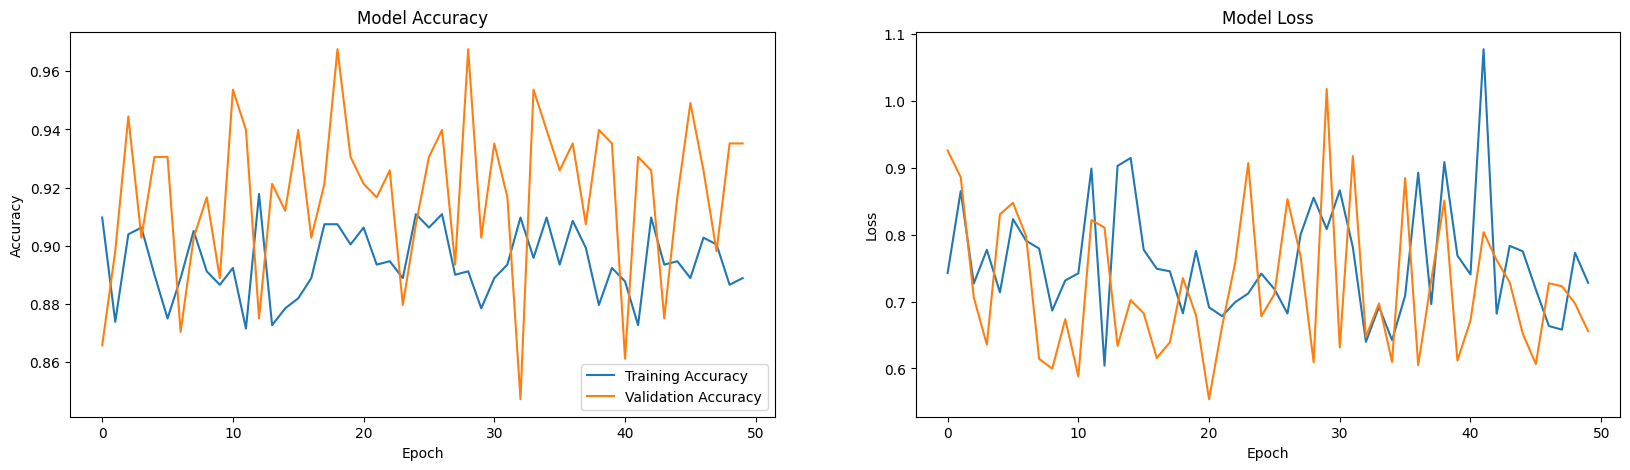

In [34]:
def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')

    plt.show()


print("val_accuracy: ", history.history['val_accuracy'])
print("accuracy: ", history.history['accuracy'])
print("val_loss: ", history.history['val_loss'])
print("loss: ", history.history['loss'])

plot_history(history)
#plot_history(hypermodel_history)



In [6]:
for name, value in best_hps.values.items():
    print(f"{name}: {value}")


tuner.results_summary(num_trials=10)

output_dim_prev_event: 35
output_dim_prev_prev_event: 35
output_dim_session_id: 30
output_dim_device_id: 15
output_dim_output: 40
units: 368
layers: 10
learning_rate: 0.1
optimizer: adam
regularization: l2
lambda: 0.88
Results summary
Results in trained_models\DI_6
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 10 summary
Hyperparameters:
output_dim_prev_event: 35
output_dim_prev_prev_event: 35
output_dim_session_id: 30
output_dim_device_id: 15
output_dim_output: 40
units: 368
layers: 10
learning_rate: 0.1
optimizer: adam
regularization: l2
lambda: 0.88
Score: 3.1751814683278403

Trial 18 summary
Hyperparameters:
output_dim_prev_event: 30
output_dim_prev_prev_event: 30
output_dim_session_id: 25
output_dim_device_id: 20
output_dim_output: 25
units: 240
layers: 12
learning_rate: 0.1
optimizer: adam
regularization: l2
lambda: 0.65
Score: 3.215389092763265

Trial 23 summary
Hyperparameters:
output_dim_prev_event: 40
output_dim_prev_prev_event: 30
output_dim_sessi

In [19]:
print(all_sessions['content_id'].value_counts())

content_id
31    45
25    35
28    30
1     25
35    17
5     16
29    14
7     10
11     8
8      6
14     6
37     5
15     4
33     4
34     4
24     4
23     3
38     3
36     3
18     2
6      2
20     2
27     2
32     2
21     1
22     1
10     1
9      1
13     1
12     1
3      1
19     1
4      1
16     1
2      1
30     1
17     1
0      1
26     1
Name: count, dtype: int64
